In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.av_dataset import Dataset

/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting


/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [5]:
avdf_all = Dataset().get_data(use_robust_av = False)
avdf_ran = Dataset().get_data(use_robust_av = False, control_types=['ran'])
avdf_moi = Dataset().get_data(use_robust_av = False, control_types=['moi'])
avdf_ems = Dataset().get_data(use_robust_av = False, control_types=['ems'])

avdf_ran_train = avdf_ran[0]
avdf_ran_tuning = avdf_ran[1]
avdf_ran_testing = avdf_ran[2]

avdf_all_train = avdf_all[0]
avdf_all_tuning = avdf_all[1]
avdf_all_testing = avdf_all[2]

avdf_ems_train = avdf_ems[0]
avdf_ems_tuning = avdf_ems[1]
avdf_ems_testing = avdf_ems[2]

avdf_moi_train = avdf_moi[0]
avdf_moi_tuning = avdf_moi[1]
avdf_moi_testing = avdf_moi[2]


### Leonard (2011)

In [6]:
Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck','Torticollis',
          'SubInj_TorsoTrunk','Predisposed','HighriskDiving','HighriskMVC']
RF = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck','Torticollis',
          'LOC','NonAmbulatory','HighriskDiving','HighriskMVC']

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

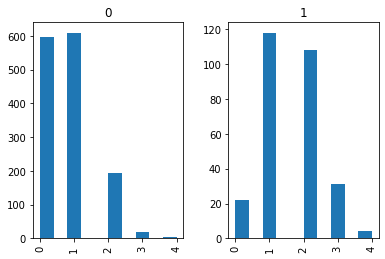

In [103]:
avdf_all_train['indicator'] = avdf_all_train[Leonard].sum(axis = 1)
avdf_all_train['indicator'].hist(by = avdf_all_train['csi_injury'])

In [92]:
def find_best(data, v_list, method = "gini"):
    '''
    find the best one to split the data from a variable list
    
    Parameters:
    data: same structure as what we get from Dataset().get_data()[0]
    v_list: names of variable names we are considering
    '''
    
    v = len(v_list)
    n = data.shape[0]
    
    score = [1]*v
    
    for i in range(v):
        
        variable = v_list[i]
        
        v1c1 = data[(data[variable] == 1) & (data['csi_injury'] == 1)].shape[0]
        v1c0 = data[(data[variable] == 1) & (data['csi_injury'] == 0)].shape[0]
        if (v1c1+v1c0) == 0:
            p1 = 1/2
        else:
            p1 = v1c1/(v1c1+v1c0)
        
        v0c1 = data[(data[variable] == 0) & (data['csi_injury'] == 1)].shape[0]
        v0c0 = data[(data[variable] == 0) & (data['csi_injury'] == 0)].shape[0]
        if (v0c1+v0c0) == 0:
            p2 = 1/2
        else:
            p2 = v0c1/(v0c1+v0c0)
        
        if method == 'gini':
            score[i] = (v1c1+v1c0)/n * p1 * (1-p1) + (v0c1+v0c0)/n * p2 * (1-p2)
            
        elif method == 'semi_gini':
            score[i] = 1-p1
            
        # print(variable, p1, score[i])
    
    ind = score.index(min(score))
    variable_best = v_list[ind]
    v_list.remove(variable_best)
    data_update = data[data[variable_best] == 0]
    
    return [variable_best, v_list, data_update]

def find_best_two(data, v_list, method = "gini"):
    '''
    find the best one to split the data from a variable list
    
    Parameters:
    data: same structure as what we get from Dataset().get_data()[0]
    v_list: names of variable names we are considering
    '''
    
    v = len(v_list)
    n = data.shape[0]
    
    score = [1]*v
    for i in range(v):
        variable = v_list[i]
        v1c1 = data[(data[variable] == 1) & (data['csi_injury'] == 1)].shape[0]
        v1c0 = data[(data[variable] == 1) & (data['csi_injury'] == 0)].shape[0]
        if (v1c1+v1c0) == 0:
            p1 = 1/2
        else:
            p1 = v1c1/(v1c1+v1c0)
        v0c1 = data[(data[variable] == 0) & (data['csi_injury'] == 1)].shape[0]
        v0c0 = data[(data[variable] == 0) & (data['csi_injury'] == 0)].shape[0]
        if (v0c1+v0c0) == 0:
            p2 = 1/2
        else:
            p2 = v0c1/(v0c1+v0c0)
        if method == 'gini':
            score[i] = (v1c1+v1c0)/n * p1 * (1-p1) + (v0c1+v0c0)/n * p2 * (1-p2)  
        elif method == 'semi_gini':
            score[i] = 1-p1   
        # print(variable, p1, score[i])
    ind = score.index(min(score))
    variable_best = v_list[ind]
    v_list.remove(variable_best)
    data_update = data[data[variable_best] == 0]
    
    # find the second rule
    
    data_selected = data[data[variable_best] == 1]
    n0 = data_selected.shape[0]
    
    if n0 == 0:
        variable_best_two = [variable_best, "no observations"]
        return [variable_best_two, v_list, data_update]
    
    p0 = data_selected[data_selected['csi_injury'] == 1].shape[0]/n0
    score0 = p0*(1-p0)
    
    score = [1]*(v-1)
    for i in range(v-1):
        variable = v_list[i]
        
        v1c1 = data_selected[(data_selected[variable] == 1) & (data_selected['csi_injury'] == 1)].shape[0]
        v1c0 = data_selected[(data_selected[variable] == 1) & (data_selected['csi_injury'] == 0)].shape[0]
        if (v1c1+v1c0) == 0:
            p1 = 1/2
        else:
            p1 = v1c1/(v1c1+v1c0)
        v0c1 = data_selected[(data_selected[variable] == 0) & (data_selected['csi_injury'] == 1)].shape[0]
        v0c0 = data_selected[(data_selected[variable] == 0) & (data_selected['csi_injury'] == 0)].shape[0]
        if (v0c1+v0c0) == 0:
            p2 = 1/2
        else:
            p2 = v0c1/(v0c1+v0c0)
    
        score[i] = (v1c1+v1c0)/n0 * p1 * (1-p1) + (v0c1+v0c0)/n0 * p2 * (1-p2)  
    
    min_score = min(score)
    if score0 <= min_score:
        variable_best_two = [variable_best, "no need"]
    else:
        ind = score.index(min_score)
        variable_best_two = [variable_best, v_list[ind]]
    
    return [variable_best_two, v_list, data_update]


def make_decision_ob(observation, v_list):
    
    '''
    make decision by v_list with two columns
    '''
    n = len(v_list)
    for i in range(n):
        
        v0 = v_list[i][0]
        v1 = v_list[i][1]
        
        if (observation[v0].item() == 1):
            if (v1 in ["no need", 'no observations']):
                return 0
            elif (observation[v1].item() == 1):
                return 1
            
    return 0
        

def make_decision_data(data, v_list):
    
    n = data.shape[0]
    decision = [0]*n
    for i in range(n):
        observation = data.iloc[[i]]
        decision[i] = make_decision_ob(observation, v_list)
    return decision

def evaluate_vlist(data, v_list, method = 'one'):
    
    data0 = pd.DataFrame({'csi_injury': data['csi_injury']})
    
    if method == "one":
        indicator = data[v_list].sum(axis = 1)
        data0['pred'] = [1 if (i > 0) else 0 for i in indicator]
    if method == "two":
        data0['pred'] = make_decision_data(data, v_list)

    TN = data0[ (data0['pred'] == 0) & (data0['csi_injury'] == 0)].shape[0]
    TP = data0[ (data0['pred'] == 1) & (data0['csi_injury'] == 1)].shape[0]
    FN = data0[ (data0['pred'] == 0) & (data0['csi_injury'] == 1)].shape[0]
    FP = data0[ (data0['pred'] == 1) & (data0['csi_injury'] == 0)].shape[0]
    
    sensitivity = TP/(FN+TP)
    specificity = TN/(FP+TN)
    
    return [sensitivity, specificity]
    

In [93]:
data = avdf_ems_train
v_list = list(data.columns)
# v_list.remove('csi_injury')
result = find_best_two(data,v_list)
result[0]

['csi_injury', 'no need']

In [94]:
data = avdf_ems_train
v_list = list(data.columns)
v_list.remove('csi_injury')
variable_rank_ems = []
while len(v_list) > 0:
    result = find_best_two(data,v_list)
    variable_rank_ems.append(result[0])
    v_list = result[1]
    data = result[2]

In [95]:
observation = data.iloc[[1]]
v0 = variable_rank_ems[1][1]
observation[v0].item()

0.0

In [100]:
data = avdf_ems_train
evaluate_vlist(data,variable_rank_ems[0:8], method = 'two')

[0.2756183745583039, 0.9105691056910569]

In [97]:
evaluate_vlist(avdf_ems_train, Leonard)

[0.9222614840989399, 0.4742547425474255]

In [28]:
variable_rank_ems

[['FocalNeuroFindings', 'SubInj_Ext'],
 ['Torticollis', 'NonAmbulatory'],
 ['AlteredMentalStatus', 'SubInj_TorsoTrunk'],
 ['PainNeck', 'HighriskDiving'],
 ['HighriskDiving', 'no need'],
 ['Predisposed', 'LOC'],
 ['Clotheslining', 'LOC'],
 ['HighriskMVC', 'LOC'],
 ['PosMidNeckTenderness', 'SubInj_TorsoTrunk'],
 ['LOC', 'HighriskHitByCar'],
 ['axialloadtop', 'no need'],
 ['HighriskHitByCar', 'SubInj_TorsoTrunk'],
 ['NonAmbulatory', 'TenderNeck'],
 ['SubInj_Ext', 'no need'],
 ['AxialLoadAnyDoc', 'SubInj_Face'],
 ['TenderNeck', 'no need'],
 ['SubInj_Face', 'no need'],
 ['SubInj_Head', 'no oobservations'],
 ['SubInj_TorsoTrunk', 'no oobservations'],
 ['HighriskFall', 'no oobservations'],
 ['HighriskHanging', 'no oobservations'],
 ['HighriskOtherMV', 'no oobservations']]

In [254]:
data = avdf_ems_train
v_list = list(data.columns)
v_list.remove('csi_injury')
variable_rank_ems = []
while len(v_list) > 0:
    result = find_best(data,v_list)
    variable_rank_ems.append(result[0])
    v_list = result[1]
    data = result[2]

In [255]:
data = avdf_moi_train
v_list = list(data.columns)
v_list.remove('csi_injury')
variable_rank_moi = []
while len(v_list) > 0:
    result = find_best(data,v_list)
    variable_rank_moi.append(result[0])
    v_list = result[1]
    data = result[2]

In [256]:
variable_rank_ems[0:8] 

['FocalNeuroFindings',
 'Torticollis',
 'AlteredMentalStatus',
 'PainNeck',
 'HighriskDiving',
 'Predisposed',
 'Clotheslining',
 'HighriskMVC']

In [257]:
variable_rank_moi[0:8] 

['FocalNeuroFindings',
 'AlteredMentalStatus',
 'PainNeck',
 'Torticollis',
 'Predisposed',
 'HighriskDiving',
 'Clotheslining',
 'HighriskMVC']

In [258]:
Leonard

['AlteredMentalStatus',
 'FocalNeuroFindings',
 'PainNeck',
 'Torticollis',
 'SubInj_TorsoTrunk',
 'Predisposed',
 'HighriskDiving',
 'HighriskMVC']

In [81]:
evaluate_vlist(avdf_ems_train, Leonard)

[0.9222614840989399, 0.4742547425474255]

In [261]:
evaluate_vlist(avdf_ran_train, variable_rank_moi[0:8])

[0.9187279151943463, 0.40892193308550184]

In [262]:
evaluate_vlist(avdf_ran_tuning, Leonard)

[0.9166666666666666, 0.4207650273224044]

In [263]:
evaluate_vlist(avdf_ran_tuning, variable_rank_moi[0:8])

[0.90625, 0.4426229508196721]

In [289]:
data = avdf_ran_train
v_list = list(data.columns)
v_list.remove('csi_injury')
variable_rank = []
while len(v_list) > 0:
    result = find_best(data,v_list,method = 'semi_gini')
    variable_rank.append(result[0])
    v_list = result[1]
    data = result[2]

In [291]:
print(evaluate_vlist(avdf_ran_train, Leonard))
print(evaluate_vlist(avdf_ran_train, variable_rank[0:11]))

[0.9222614840989399, 0.395910780669145]
[0.9328621908127208, 0.3903345724907063]


In [295]:
print(evaluate_vlist(avdf_ran_tuning, Leonard))
print(evaluate_vlist(avdf_ran_tuning, variable_rank[0:11]))

[0.9166666666666666, 0.4207650273224044]
[0.9270833333333334, 0.4098360655737705]


In [297]:
variable_rank[0:11]

['HighriskDiving',
 'FocalNeuroFindings',
 'Predisposed',
 'Clotheslining',
 'SubInj_TorsoTrunk',
 'Torticollis',
 'HighriskMVC',
 'axialloadtop',
 'AlteredMentalStatus',
 'HighriskHanging',
 'PainNeck']

In [287]:
Leonard

['AlteredMentalStatus',
 'FocalNeuroFindings',
 'PainNeck',
 'Torticollis',
 'SubInj_TorsoTrunk',
 'Predisposed',
 'HighriskDiving',
 'HighriskMVC']